<a href="https://colab.research.google.com/github/szh141/UVA-AMF/blob/main/Lung_CT_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IQ-OTH/NCCD lung cancer dataset

https://python.plainenglish.io/image-classification-for-prediction-of-lung-cancer-66b3ab5e7d04

https://www.kaggle.com/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset

 a total of 1190 images representing CT scan slices of 110 cases. These cases are grouped into three classes: normal, benign, and malignant. Out of these, 40 cases are diagnosed as malignant; 15 cases are diagnosed as benign; and 55 cases are classified as normal cases.

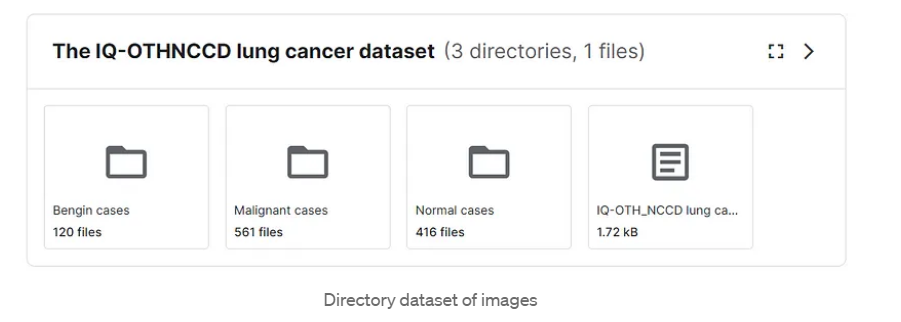

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D,Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
import os
import cv2

In [2]:
bengin_path = r"/a1/Bengin cases"
malignant_path = r"/a1/Malignant cases"
normal_path = r"/a1/Normal cases"

img_classes = ["Bengin cases", "Malignant cases", "Normal cases"]
path_list = [bengin_path, malignant_path, normal_path]

img_path = []
class_labels = []
for i, dir_list in enumerate(path_list):
    name_img = os.listdir(dir_list)
    for name_file in name_img:
        img = os.path.join(dir_list,name_file)
        img_path.append(img)
        class_labels.append(img_classes[i])

df = pd.DataFrame({"img_path" : img_path,
                  "label" : class_labels})

df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset/Bengin cases'

In [ ]:
for category, group in df.groupby("label"):
    fig, ax = plt.subplots(1,3, figsize = (5,5))
    ax = ax.ravel()
    for i, (_,r) in enumerate(group.sample(3).iterrows()):
        img = cv2.imread(r.img_path)
        ax[i].imshow(img)
        ax[i].axis("off")
        ax[i].set_title(r.label)
    plt.show()

Explore the data

In [ ]:
countData = df["label"].value_counts().reset_index()
fig = px.histogram(data_frame = countData, x = "label", y = "count")
fig.show()

In [ ]:
sizes = []
resolutions = []
color_distributions = []

for img_path in df["img_path"]:
    #load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #Get image size
    size = os.path.getsize(img_path)
    sizes.append(size)
    #Extract the resolution of images
    resolution = img.shape[:2]
    resolutions.append(resolution)
    #Extract color distribution
    mean_color_distributions = np.bincount(img.flatten(), minlength = 256)
    color_distributions.append(mean_color_distributions)
sizes = np.array(sizes)
resolutions = np.array(resolutions)
color_distributions = np.array(color_distributions)

In [ ]:
#Sizes in MB
sizes_MB = []
for img_path in df["img_path"]:
    #load image
    img = cv2.imread(img_path)
    #Get image size
    size = os.path.getsize(img_path)
    sizes_MB.append(size/1_000_000)

fig = px.histogram(x=sizes_MB, nbins = 50, title = "Distribution of Image Sizes")
fig.update_layout(xaxis_title = "File Size (MB)",
                 yaxis_title = "Number of Images",
                 showlegend = False,
                 bargap = 0.1,
                 bargroupgap = 0.1)
fig.update_traces(marker = dict(color = "green"))
fig.show()

In [ ]:
fig = px.scatter(x = resolutions[:,0], y = resolutions[:,1], title = "Distribution of Image Resolution")
fig.update_layout(
    xaxis_title = "Width (Pixel)",
    yaxis_title = "Height (Pixel)",
    showlegend = False,
    hovermode = "closest"
)
fig.update_traces(marker = dict(color="red"))
fig.show()

In [ ]:
import plotly.graph_objects as go
mean_color_distributions = np.mean(color_distributions, axis = 0)
fig = go.Figure(
    go.Bar(x = np.arange(256), y = mean_color_distributions, name = "Mean Color Distributions"
))
fig.update_layout(
    title = "Mean Color Distribution",
    xaxis_title = "Color Values",
    yaxis_title = "Number of Pixel"
)
fig.show()

Data preprocessing

In [ ]:
train_ratio = 0.70
test_ratio = 0.15
val_ratio = 0.15

df_train, df_test_val = train_test_split(df, train_size = train_ratio, random_state = 42)
df_test, df_val = train_test_split(df_test_val, train_size = test_ratio/(test_ratio+val_ratio), random_state = 42)

print(f"Train shape = {df_train.shape}")
print(f"Test shape = {df_test.shape}")
print(f"Validation shape = {df_val.shape}")

In [ ]:
def preprocessing_denoise(img):
    denoise_img = cv2.medianBlur(img, 1)
    denoise_img = cv2.cvtColor(denoise_img, cv2.COLOR_BGR2RGB)
    return denoise_img

Data Augmentation

In [ ]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

image_size = (IMG_WIDTH, IMG_HEIGHT)
batch_size = 32

TRAIN_DATAGEN = ImageDataGenerator(rescale = 1./255.,
                                   preprocessing_function = preprocessing_denoise,
                                  rotation_range = 30,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.2,
                                  shear_range = 0.1,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

TEST_DATAGEN = ImageDataGenerator(rescale = 1./255.)

train_generator = TRAIN_DATAGEN.flow_from_dataframe(
    df_train,
    x_col = "img_path",
    y_col = "label",
    target_size = image_size,
    batch_size = batch_size,
    color_mode = "rgb",
    class_mode = "categorical",
    shuffle = True
)

val_generator = TEST_DATAGEN.flow_from_dataframe(
    df_val,
    x_col = "img_path",
    y_col = "label",
    target_size = image_size,
    batch_size = batch_size,
    color_mode = "rgb",
    class_mode = "categorical",
    shuffle = True
)

test_generator = TEST_DATAGEN.flow_from_dataframe(
    df_test,
    x_col = "img_path",
    y_col = "label",
    target_size = image_size,
    batch_size = batch_size,
    color_mode = "rgb",
    class_mode = "categorical",
    shuffle = True
)

In [ ]:
#Weight Class
class_weights = class_weight.compute_class_weight(
           class_weight = 'balanced',
            classes = np.unique(train_generator.classes),
            y = train_generator.classes)

train_class_weights = dict(enumerate(class_weights))

for idx, weight, in train_class_weights.items():
    class_name = classes[idx]
    print(f"{class_name} : {weight}")

Custom CNN

In [ ]:
model1 = Sequential([
    Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), input_shape = (224, 224, 3), activation = "relu", padding = "same"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),

    Conv2D(filters = 64, kernel_size = (3,3), strides = (1,1), padding = "valid"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),

    Conv2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = "valid"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),

    Conv2D(filters = 128, kernel_size = (3,3), strides = (1,1), padding = "valid"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),

    Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), padding = "valid"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),

    Conv2D(filters = 256, kernel_size = (3,3), strides = (1,1), padding = "valid"),
    MaxPool2D(pool_size = (2,2)),
    BatchNormalization(),

    Flatten(),
    Dense(4096, activation = "relu"),
    Dropout(0.5),
    Dense(256),
    Dropout(0.25),
    Dense(3, activation = "softmax")
])

model1.summary()

In [ ]:
model1.compile(
    loss = "categorical_crossentropy",
    optimizer = Adam(learning_rate = 0.0005),
    metrics = ["accuracy"],
)

epochs = 50
history = model1.fit(train_generator,
                   steps_per_epoch = len(train_generator),
                   batch_size = 32,
                   validation_data = val_generator,
                   validation_steps = len(val_generator),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True),
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, mode='min')
                              ],
                   epochs = epochs)

In [ ]:
def history_plot(epochs, history):
    fig1 = make_subplots()
    fig1.add_trace(go.Scatter(x = np.arange(1,epochs+1), y = history.history["accuracy"], name = "Training Accuracy"))
    fig1.add_trace(go.Scatter(x = np.arange(1,epochs+1), y = history.history["val_accuracy"], name = "Validation Accuracy"))
    fig1.update_layout(title = "Training and Validation Accuracy", xaxis_title = "Epoch", yaxis_title = "Accuracy")
    fig1.show()

    fig2 = make_subplots()
    fig2.add_trace(go.Scatter(x = np.arange(1,epochs+1), y = history.history["loss"], name = "Training Loss"))
    fig2.add_trace(go.Scatter(x = np.arange(1,epochs+1), y = history.history["val_loss"], name = "Validation Loss"))
    fig2.update_layout(title = "Training and Validation Loss", xaxis_title = "Epoch", yaxis_title = "Loss")
    fig2.show()

history_plot(epochs, history)

In [ ]:
def evaluate_model(model, test_generator):
    #Calculate test loss and accuracy
    results = model.evaluate(test_generator, verbose = 0)
    print(f"Test Loss = {results[0]}")
    print(f"Test Accuracy = {results[1]}")

evaluate_model(model1, test_generator)

Transfer Learning Inception V3

In [ ]:
#Define base_model of InceptionV3
base_model = InceptionV3(input_shape = (IMG_WIDTH, IMG_HEIGHT, 3), include_top = False, weights = "imagenet")

#Freeze all layers
for layer in base_model.layers:
    layer.trainable = False

#Add Custom layers
model2 = Sequential()
model2.add(Input(shape = (IMG_WIDTH, IMG_HEIGHT, 3)))
model2.add(base_model)
model2.add(Flatten())
model2.add(Dense(1024, activation = "relu"))
model2.add(Dropout(0.4))
model2.add(Dense(3, activation = "softmax"))

#Compile and Training the model
epochs = 50
model2.compile(optimizer = Adam(0.0005),
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])
history = model2.fit(train_generator,
                   steps_per_epoch = len(train_generator),
                   batch_size = 64,
                   validation_data = val_generator,
                   validation_steps = len(val_generator),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True),
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
                              ],
                   epochs = epochs)

In [ ]:
#Plot the graph
history_plot(epochs, history)

In [ ]:
evaluate_model(model2, test_generator)

Fine Tuning InceptionV3 Model


In [ ]:
# All layers does not freeze
base_model.trainable = True
#Compile the model
model2.compile(optimizer = Adam(0.00001),
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])
#Training the model
epochs = 50
history = model2.fit(train_generator,
                   steps_per_epoch = len(train_generator),
                   batch_size = 64,
                   validation_data = val_generator,
                   validation_steps = len(val_generator),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True),
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
                              ],
                   epochs = epochs)

In [ ]:
history_plot(epochs, history)

In [ ]:
evaluate_model(model2, test_generator)

Transfer Learning VGG16

In [ ]:
#Define base mode of VGG16
base_model_vgg16 = VGG16(input_shape = (IMG_WIDTH, IMG_HEIGHT, 3), include_top = False, weights = "imagenet")

#Freeze all layers VGG16 model
for layer in base_model_vgg16.layers:
    layer.trainable = False

#Add custom layers
model3 = Sequential()
model3.add(Input(shape = (IMG_WIDTH, IMG_HEIGHT, 3)))
model3.add(base_model)
model3.add(Flatten())
model3.add(Dense(1024, activation = "relu"))
model3.add(Dropout(0.4))
model3.add(Dense(3, activation = "softmax"))

#Compile model
model3.compile(optimizer = Adam(0.0005),
             loss = "categorical_crossentropy",
             metrics = ["accuracy"])

#Training the model
epochs = 50
history = model3.fit(train_generator,
                   steps_per_epoch = len(train_generator),
                   batch_size = 64,
                   validation_data = val_generator,
                   validation_steps = len(val_generator),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True),
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, mode='min')
                              ],
                   epochs = epochs)

In [ ]:
history_plot(epochs, history)


In [ ]:
evaluate_model(model3,test_generator)


Fine tune VGG16

In [ ]:
#Set the training layer jus block_conv1
base_model_vgg16.trainable = True
set_trainable = False
for layer in base_model_vgg16.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

#Compile the model
model3.compile(optimizer = Adam(0.00001),
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

#Training the model
epochs = 50
history = model3.fit(train_generator,
                   steps_per_epoch = len(train_generator),
                   batch_size = 64,
                   validation_data = val_generator,
                   validation_steps = len(val_generator),
                   class_weight = train_class_weights,
                   callbacks=[
                               EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True),
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, mode='min')
                              ],
                   epochs = epochs)

In [ ]:
history_plot(epochs,history)


In [ ]:
evaluate_model(model3, test_generator)


results of all models

In [ ]:
models = [model1, model2, model3]
loss = []
accuracy = []
for model in models:
    results = model.evaluate(test_generator, verbose = 0)
    loss.append(results[0])
    accuracy.append(results[1])

name_models = ["CNN (Custom)", "InceptionV3", "VGG16"]
df_loss_acc = pd.DataFrame(data = {"Name_Models" : name_models,
                                  "Loss" : loss,
                                  "Accuracy" : accuracy})

fig = px.bar(data_frame = df_loss_acc, x = "Name_Models", y = ["Accuracy", "Loss"],
            barmode = "group",
            text_auto = ".3f")
fig.show()


In [ ]:
model3.save("VGG16.keras")


Conclusion
In this article, we can predict lung cancer from CT scan images with three different classes Benign cases, Malignant cases, and Normal cases. In the beginning, we can load the dataset and visualization of them. Next, we do an EDA process such as creating graphs to know the size distribution of images, resolution of images, and mean color distribution of images. Then, we create image augmentation using ImageDataGenerator and create the class weights to handle the imbalanced training dataset. We created three models such as the Custom CNN model and transfer learning using pre-trained models InceptionV3 and VGG16. For the results get the VGG16 the great model gives accuracy and loss is 0.927 and 0.213.